# Quantized FACILE Training with Brevitas
This notebook walks through the steps to train and and validate the Pytorch Brevitas reconstruction of the HCAL Facile model

Initial Pytorch conversion by Vladimir Oveckhin
Pytorch to Brevitas conversion by Matthew Trahms

In [1]:
#install pandas (missing in FINN env)
!pip install --user pandas

     |################################| 9.5MB 2.1MB/s eta 0:00:01


In [1]:
#import the necessary classes and functions
from train import train
from metrics import Metrics
from quant_model import QuantNet
from quant_modelV2 import QuantNet_opt
#from quantmodelV2_with_proc import QuantNet_opt_proc

In [2]:
models_folder = 'quant_models'

X_train shape: (229538, 14)
X_val shape: (12752, 14)
X_test shape: (12752, 14)
Y_train shape: (229538, 1)
Y_val shape: (12752, 1)
Y_test shape: (12752, 1)
Using saved split data
Number of batches per epoch: 460
# of Model parameters: 983.0
# of features: 14


Epoch 1
Ave Train Loss: 0.0008070860303946374
Ave Val Loss: 0.0007646223682082881
Ave Q Train Loss: 1.020063252708251
Ave Q Val Loss: 1.204757124447314
<class 'quant_modelV2.QuantNet_opt'>
Min Ave Val Loss: 0.0007646223682082881
Saved model


Epoch 2
Ave Train Loss: 0.000612584354056513
Ave Val Loss: 0.0005546301250419623
Ave Q Train Loss: 0.7506161007472627
Ave Q Val Loss: 0.5413604470687349
<class 'quant_modelV2.QuantNet_opt'>
Min Ave Val Loss: 0.0005546301250419623
Saved model


Epoch 3
Ave Train Loss: 0.0006001773752268688
Ave Val Loss: 0.0005261735146961068
Ave Q Train Loss: 0.7280295962258803
Ave Q Val Loss: 0.5372262880523949
<class 'quant_modelV2.QuantNet_opt'>
Min Ave Val Loss: 0.0005261735146961068
Saved model


Epoch 4


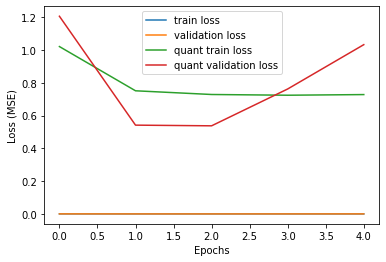

<class 'quant_modelV2.QuantNet_opt'>


In [3]:
#train (mimicing structure in train.py)
metrics = Metrics()
model = None
try:
    model = train(QuantNet_opt, metrics=metrics, models_folder_path=models_folder, quantized=True)
except KeyboardInterrupt:
    print("Interrupted")
finally:
    metrics.plot_losses()
print(type(model))

In [5]:
#test inference
import torch
import utils
from torch.utils.data import DataLoader
from processing_for_train import FACILE_preproc as preproc
from processing_for_train import FACILE_postproc as postproc
from processing_for_train import FACILE_preproc_out as preproc_out

batch_size=1
train_set, val_set, test_set, n_features = utils.load_torch_datasets()
gen_params = {
                "batch_size": batch_size,
                "shuffle": True,
            }
test_gen = DataLoader(test_set, **gen_params)
#ensure model in evaluation mode
model.eval()
loss_fn = torch.nn.MSELoss()

total_test_loss = 0
total_test_loss_quant = 0
n_test_samples = 0

for test_batch, labels_batch in test_gen:
    n_test_samples += test_batch.shape[0]

    labels_batch_q = labels_batch
    labels_batch = preproc_out(labels_batch.float())
    output_batch = preproc(test_batch.float())
    output_batch = model(output_batch)
    #output_batch = postproc(output_batch).float()
    #output_batch = torch.trunc(output_batch)
    output_batch_quant = torch.round(output_batch)
    output_batch_quant = postproc(output_batch_quant)
    q_loss = loss_fn(output_batch_quant.float(), labels_batch_q.float())
    total_test_loss_quant += q_loss.item()
    loss = loss_fn(output_batch.float(), labels_batch.float())
    total_test_loss += loss.item()

ave_test_loss = total_test_loss / n_test_samples
ave_test_loss_q = total_test_loss_quant / n_test_samples

print(f"Ave Test Loss: {ave_test_loss}")
print(f"Ave Q Test Loss: {ave_test_loss_q}")

X_train shape: (229538, 14)
X_val shape: (12752, 14)
X_test shape: (12752, 14)
Y_train shape: (229538, 1)
Y_val shape: (12752, 1)
Y_test shape: (12752, 1)
Using saved split data
Ave Test Loss: 0.2490816806893871
Ave Q Test Loss: 268.739261180091


In [12]:
#export to onnx finn format
from brevitas.onnx import export_finn_onnx
input_shape = [500,14]
export_finn_onnx(model, input_shape, models_folder + "/facileV3_4b_500.onnx")